In [1]:
import torch
import pickle
import argparse
import numpy as np
import torch.nn as nn
from torchmetrics import Accuracy
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import ImageFolder
import os
from fastai.vision.all import untar_data, URLs
import pandas as pd
from pytorch_lightning import Trainer
from dime.data_utils import HistopathologyDownsampledDataset
from dime.utils import MaskLayer2d
from dime import MaskingPretrainer
from dime import CMIEstimator, MaskLayer
from dime.resnet_imagenet import resnet18, resnet34, Predictor, ValueNetwork, ResNet18Backbone, resnet50
from dime.vit import PredictorViT, ValueNetworkViT
import timm
import matplotlib.pyplot as plt

/homes/gws/sgadgil/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset

In [2]:
# Load test dataset, split into train/val
mnist_dataset = MNIST('/tmp/mnist/', download=True, train=True,
                      transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(torch.flatten)]))
np.random.seed(0)
# Load test dataset
test_dataset = MNIST('/tmp/mnist/', download=True, train=False,
                     transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(torch.flatten)]))

device = torch.device('cuda:2')

test_dataloader = DataLoader(
        test_dataset, batch_size=128, shuffle=False, pin_memory=True,
        drop_last=True, num_workers=4)

In [31]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /tmp/mnist/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )

# Set up networks

In [5]:
acc_metric = Accuracy(task='multiclass', num_classes=10)
d_in = 784
d_out = 10
hidden = 512
dropout = 0.3

# Outcome Predictor
predictor = nn.Sequential(
    nn.Linear(d_in * 2, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_out)).to(device)

# CMI Predictor
value_network = nn.Sequential(
    nn.Linear(d_in * 2, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_in)).to(device)

value_network[0] = predictor[0]
value_network[3] = predictor[3]

mask_layer = MaskLayer(append=True, mask_size=d_in)

trainer = Trainer(
                    accelerator='gpu',
                    devices=[device.index],
                    precision=16
                )

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Evaluate Penalized Policy

In [ ]:
for trial in range(0, 5):
    results_dict = {"acc": {}}
    path = "/homes/gws/sgadgil/Projects/DIME/experiments/MNIST/logs/max_features_50_eps_0.05_with_decay_rate_0.2_save_best_loss_trial_0/version_0/checkpoints/best_val_loss_model.ckpt"

    greedy_cmi_estimator = CMIEstimator.load_from_checkpoint(path,
                                                             value_network=value_network,
                                                             predictor=predictor,
                                                             mask_layer=mask_layer,
                                                             lr=1e-3,
                                                             min_lr=1e-6,
                                                             max_features=50,
                                                             eps=0.05,
                                                             loss_fn=nn.CrossEntropyLoss(reduction='none'),
                                                             val_loss_fn=acc_metric,
                                                             eps_decay=0.2,
                                                             eps_steps=10,
                                                             patience=3,
                                                             feature_costs=None).to(device)
    avg_num_features_lamda = []
    accuracy_scores_lamda = []
    all_masks_lamda =[]

    lamda_values = list(np.geomspace(0.00016, 0.28, num=10))
    for lamda in lamda_values:
        metric_dict = greedy_cmi_estimator.inference(trainer, test_dataloader, feature_costs=None, lam=lamda)
        
        y = metric_dict['y']
        pred = metric_dict['pred']
        accuracy_score = acc_metric(pred, y)
        final_masks = np.array(metric_dict['mask'])
        accuracy_scores_lamda.append(accuracy_score)
        avg_num_features_lamda.append(np.mean(np.sum(final_masks, axis=1)))
        results_dict['acc'][np.mean(np.sum(final_masks, axis=1))] = accuracy_score

        print(f"Lambda={lamda}, Acc={accuracy_score}, Avg. num features={np.mean(np.sum(final_masks, axis=1))}")
        all_masks_lamda.append(final_masks)
    with open(f'results/mnist_lamda_ours_trial_{trial-4}.pkl', 'wb') as f:
        pickle.dump(results_dict, f)


# Evaluate Budget Constrained Policy

In [17]:
results_dict = {"acc": {}}
# for trial in range(0, 5):
path = "/projects/leelab/sgadgil/Projects/DIME/experiments/MNIST/logs/max_features_50_eps_0.05_with_decay_rate_0.2_save_best_loss_with_entropy_fix_trial_0/version_4/checkpoints/best_val_perf_model.ckpt"
greedy_cmi_estimator = CMIEstimator.load_from_checkpoint(path,
                                                         value_network=value_network,
                                                         predictor=predictor,
                                                         mask_layer=mask_layer,
                                                         lr=1e-3,
                                                         min_lr=1e-6,
                                                         max_features=50,
                                                         eps=0.05,
                                                         loss_fn=nn.CrossEntropyLoss(reduction='none'),
                                                         val_loss_fn=acc_metric,
                                                         eps_decay=0.2,
                                                         eps_steps=10,
                                                         patience=3,
                                                         feature_costs=None)
avg_num_features_budget = []
accuracy_scores_budget = []
all_masks_budget=[]

max_budget_values = [10] #[3] + list(range(5, 30, 5))
for budget in max_budget_values:
    metric_dict_budget = greedy_cmi_estimator.inference(trainer, test_dataloader, 
                                                                    feature_costs=None, budget=budget)

    y = metric_dict_budget['y']
    pred = metric_dict_budget['pred']
    accuracy_score = acc_metric(pred, y)
    final_masks = np.array(metric_dict_budget['mask'])
    accuracy_scores_budget.append(accuracy_score)
    avg_num_features_budget.append(np.mean(np.sum(final_masks, axis=1)))
    results_dict['acc'][np.mean(np.sum(final_masks, axis=1))] = accuracy_score
    print(f"Budget={budget}, Acc={accuracy_score}, Avg. num features={np.mean(np.sum(final_masks, axis=1))}")

all_masks_budget.append(final_masks)
# with open(f'results/mnist_ours_trial_{trial-4}.pkl', 'wb') as f:
#     pickle.dump(results_dict, f)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.04it/s]
Budget=10, Acc=0.7473999857902527, Avg. num features=10.0


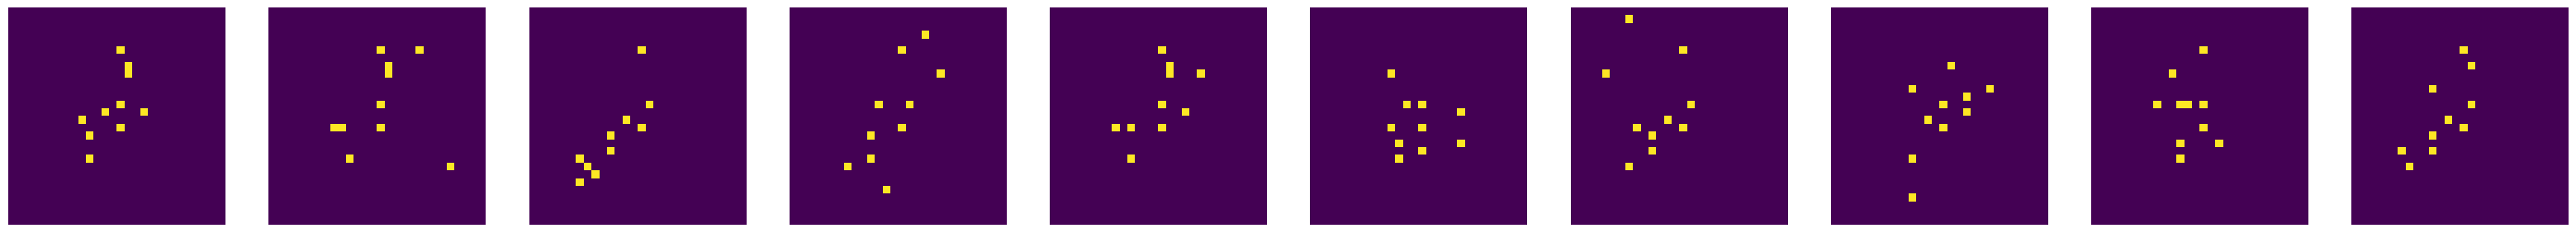

In [44]:
fig,axes = plt.subplots(1, 10, figsize=(40, 7))
import random
i=0
for j in random.sample(range(1, 10000), 10):
    inds = final_masks[j] > 0
    zeros = np.zeros(784)
    zeros[inds] = 1
    axes[i].axis("off")
    axes[i].set_aspect('equal')

    axes[i].imshow(zeros.reshape(28, 28))
    i+= 1
#     plt.show()
plt.savefig('mnist_features.png', bbox_inches='tight')
plt.show()



In [20]:
final_masks[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.